In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import torchvision.datasets as D
import torch.nn.functional as F
import numpy as np
import pickle
from matplotlib import pyplot as plt
from utils.utils import MyDataset, show_image, visualise_output
import sys
sys.path.append("..")
from networks.autoencoder import FireAutoencoder
import matplotlib
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import scipy

In [98]:
train_dataset = MyDataset(root='../data/complete_random/homo_2/Sub20x20_full_grid_.pkl',
                             tform=lambda x: torch.from_numpy(x, dtype=torch.float
))

In [294]:
latent_dims = 32
capacity = latent_dims//2 
input_size = 20
epochs = 100
sigmoid = True
net = FireAutoencoder(capacity, input_size, latent_dims, sigmoid)
net.load_state_dict(torch.load(f'weights/homo_2_sub20x20_latent={latent_dims}_capacity={capacity}_{epochs}_sigmoid={sigmoid}.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [295]:
full_loader  = torch.utils.data.DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)

In [296]:
all_images, all_r = next(iter(full_loader))

In [297]:
embeddings = net.encode(all_images)

In [298]:
with torch.no_grad():
    X, y = embeddings.numpy(), all_r.numpy()

In [299]:
reg = LinearRegression().fit(X, y)

In [300]:
reg.score(X, y)

0.05730343658011494

In [301]:
reg.predict(X)

array([-791.82104, -771.4831 , -804.07117, ..., -775.3223 , -758.3699 ,
       -783.36755], dtype=float32)

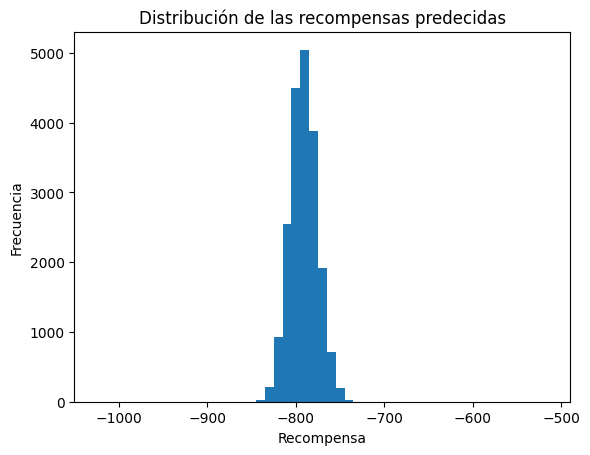

In [302]:
bins = np.arange(-1020, -500, 10)
plt.hist(reg.predict(X), bins=bins, align='left')
plt.title('Distribución de las recompensas predecidas')
plt.xlabel('Recompensa')
plt.ylabel('Frecuencia')
plt.savefig(f"linear_regresion/reward_classes_distr_{latent_dims}_{epochs}_sigmoid={sigmoid}.png.png")
plt.show()

In [303]:
def linear_func(x):
    return -(np.dot(x,reg.coef_) + reg.intercept_)

In [304]:
res = scipy.optimize.minimize(linear_func, x0=np.zeros(latent_dims))

In [305]:
res

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -9188308461.458979
        x: [ 3.060e+07  6.211e+07 ...  9.609e+07 -6.536e+07]
      nit: 2
      jac: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
 hess_inv: [[ 4.051e+04  8.221e+04 ...  1.272e+05 -8.653e+04]
            [ 8.221e+04  1.668e+05 ...  2.581e+05 -1.756e+05]
            ...
            [ 1.272e+05  2.581e+05 ...  3.994e+05 -2.717e+05]
            [-8.653e+04 -1.756e+05 ... -2.717e+05  1.848e+05]]
     nfev: 561
     njev: 17

In [306]:
minimum = torch.from_numpy(res.x)

In [307]:
net.float()

FireAutoencoder(
  (conv1): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (fc): Linear(in_features=800, out_features=32, bias=True)
  (fc_2): Linear(in_features=32, out_features=800, bias=True)
  (conv1_2): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2_2): ConvTranspose2d(16, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (sigmoid): Sigmoid()
)

In [308]:
solution = net.decode(minimum.float().unsqueeze(0))

In [309]:
if sigmoid:
    solution[solution>=0.5] = 1
    solution[solution<=0.5] = 0
else:
    solution[solution>0] = 1

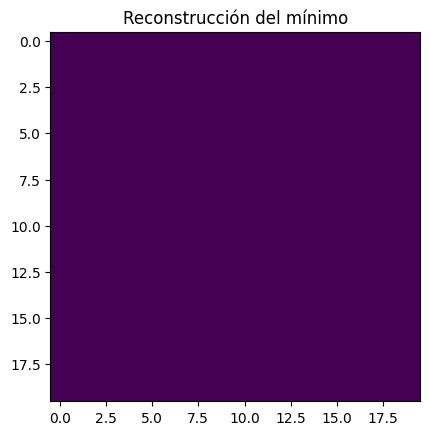

In [310]:
with torch.no_grad():
        plt.title('Reconstrucción del mínimo')
        plt.imshow(solution[0][0].numpy())
        plt.savefig(f"linear_regresion/minimum_decoding_{latent_dims}_{epochs}_sigmoid={sigmoid}.png")
        plt.show()

In [311]:
with torch.no_grad():
    print(solution[0][0].numpy())

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.